# Explore EEG data with Deep Learning 
### BNCI2014_001 with ShallowFBCSPNet

In [3]:
#!pip install --upgrade pip
#!pip install moabb
#!pip install mne
#!pip install --upgrade mne moabb



In [4]:
import matplotlib.pyplot as pyplot
import pandas as pd 
import math 
import seaborn as sns
import numpy as np

from mne import create_info
from mne.channels import make_standard_montage
from mne.io import RawArray
from mne.utils import verbose
from scipy.io import loadmat

from moabb.datasets import download as dl
from moabb.datasets.base import BaseDataset
from moabb.utils import depreciated_alias


from moabb.datasets.bnci import BNCI2014_001





In [10]:
#!pip uninstall torch_geometric -y
#!pip install torch_geometric


### Data BNCI2014_001

In [11]:
#BNCI_URL = "http://bnci-horizon-2020.eu/database/data-sets/"
#BBCI_URL = "http://doc.ml.tu-berlin.de/bbci/"




In [7]:
dataset = BNCI2014_001()
data = dataset.get_data(subjects=[1])  # Load data for subject 1


In [8]:
# Data
### 0-train and 1-test
### 0-train has 0-5 keys ???
### Same Duration for all 0-5 keys

data[1]["0train"]["2"]

<RawArray | 26 x 96735 (386.9 s), ~19.2 MiB, data loaded>

### Model shallowFBCSPNet

In [9]:
#!pip install skorch

In [12]:
from braindecode.models import ShallowFBCSPNet
import mne


import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import BNCI2014_001
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import LeftRightImagery
import tqdm

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-s

In [13]:
#!pip install tqdm

In [14]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

paradigm = LeftRightImagery()
evaluation = WithinSessionEvaluation(
    paradigm=paradigm,
    datasets=[dataset],
    overwrite=True,
    hdf5_path=None,
)
#Shallow_results = evaluation.process()



sessions = dataset.get_data(subjects=[1])
subject = 1
session_name = "0train"
run_name = "0"
raw = sessions[subject][session_name][run_name]
print(raw)
#for subject in dataset.subject_list:#, desc=f"{dataset.code}-WithinSession"):
#    print(subject)



X_EEG, y_EEG, metadata = paradigm.get_data(
                dataset=dataset,
                subjects=[subject])


<RawArray | 26 x 96735 (386.9 s), ~19.2 MiB, data loaded>


In [15]:
print(X_EEG.shape)
print(y_EEG.shape)

(288, 22, 1001)
(288,)


In [16]:
metadata
 

,subject,session,run
0,1,0train,0
1,1,0train,0
2,1,0train,0
3,1,0train,0
4,1,0train,0
...,...,...,...
283,1,1test,5
284,1,1test,5
285,1,1test,5
286,1,1test,5


In [17]:
ch_list = []
for i in range(1,X_EEG.shape[1]+1):
    string = "C"+str(i)
    ch_list.append(string)
X = np.random.randn(100, 3, 1024)  # 100 epochs, 3 channels, 4 seconds (@256Hz)
print(X.shape)

(100, 3, 1024)


In [18]:
print(len(ch_list))

22


In [19]:

#y = np.random.randint(0, 4, size=100)  # 4 classes
#print(y.shape)

def get_ints(y_data):
    y_EEG_int_vals = []
    for i in y_EEG:
        if i == "right_hand":
            y_EEG_int_vals.append(0)
        else:
            y_EEG_int_vals.append(1)
    return y_EEG_int_vals
print(get_ints)

<function get_ints at 0x000001C141205C60>


In [20]:
model = ShallowFBCSPNet(
    n_chans=22,
    n_times=1000,
    n_outputs=2,
    final_conv_length='auto',
)
#print(model)


from skorch.dataset import ValidSplit
from braindecode import EEGClassifier

net = EEGClassifier(
    'ShallowFBCSPNet',
    max_epochs = 100,
    module__final_conv_length='auto',
    train_split=ValidSplit(0.2),
    verbose=0
    # To train a neural network you need validation split, here, we use 20%.
)

In [21]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: philipwinstroemjespersen (philinthesky). Use `wandb login --relogin` to force relogin


True

In [22]:
net

<class 'braindecode.classifier.EEGClassifier'>[uninitialized](
  module=ShallowFBCSPNet,
  module__final_conv_length=auto,
)

In [23]:
acc_list = []
for i in dataset.subject_list:
    X_EEG, y_EEG, metadata = paradigm.get_data(
                dataset=dataset,
                subjects=[i])
    y_EEG_data= get_ints(y_EEG)
    info = mne.create_info(ch_names=[i for i in ch_list], sfreq=250., ch_types='eeg')
    #X = np.random.randn(100, 3, 1024)  # 100 epochs, 3 channels, 4 seconds (@256Hz)
    epochs = mne.EpochsArray(X_EEG, info=info)

    net.fit(epochs, np.array(y_EEG_data))
    print()
    subject_acc =  net.history[-1]["valid_acc"]
    print(f"Subject {i}:", subject_acc) 
    acc_list.append(subject_acc)
    #print(net.history[-1])  # Prints the last epoch's results


Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated

Subject 1: 0.8448275862068966
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated

Subject 2: 0.5517241379310345
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated

Subject 3: 0.9137931034482759
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated

Subject 4: 0.7068965517241379
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated

Subject 5: 0.5517241379310345
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated

Subject 6: 0.6551724137931034
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated

Subject 7: 0.7068965517241379
Not setting metadata
288 matching 

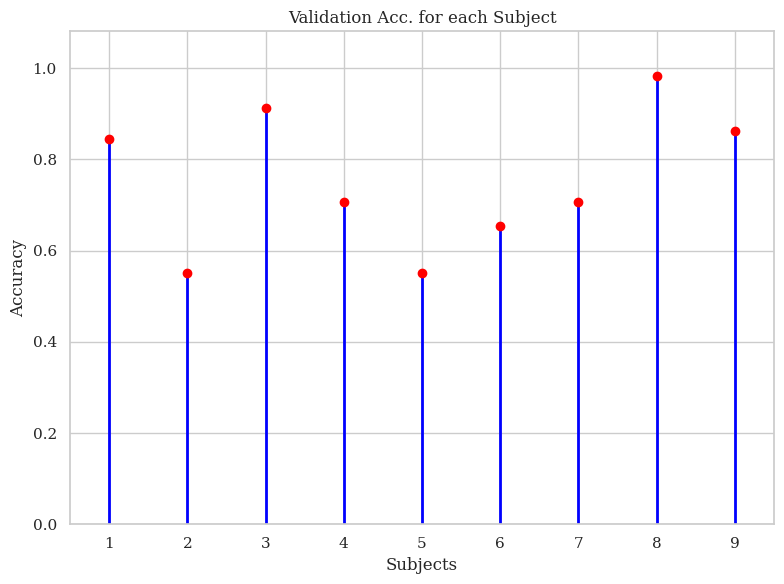

In [29]:
import matplotlib.pyplot as plt
from matplotlib import collections as matcoll
import numpy as np

if not np.issubdtype(np.array(dataset.subject_list).dtype, np.number):
    x_positions = np.arange(len(dataset.subject_list))
    x_labels = dataset.subject_list
else:
    x_positions = np.array(dataset.subject_list)
    x_labels = dataset.subject_list

# Create a list of line segments for each subject: from (x,0) to (x, accuracy)
lines = [ [(x, 0), (x, acc)] for x, acc in zip(x_positions, acc_list) ]

# Create a LineCollection from the list of segments
lc = matcoll.LineCollection(lines, colors='blue', linewidths=2)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)

# Add scatter points at the top of each line
ax.scatter(x_positions, acc_list, color='red', zorder=3)

# Set limits for x and y axes.
ax.set_xlim(min(x_positions) - 0.5, max(x_positions) + 0.5)
ax.set_ylim(0, max(acc_list) * 1.1)

# If using categorical subject names, set the tick positions and labels.
if not np.issubdtype(np.array(dataset.subject_list).dtype, np.number):
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')

ax.set_title("Validation Acc. for each Subject")
ax.set_xlabel("Subjects")
ax.set_ylabel("Accuracy")
plt.tight_layout()
plt.show()


In [31]:

print(f"Mean of the Subjects Validation Accuracy: {np.mean(acc_list)}")

Mean of the Subjects Validation Accuracy: 0.7528735632183907


# Get Temporal and Spatial Layers

In [32]:
net

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  ============================================================================================================================================
  ShallowFBCSPNet (ShallowFBCSPNet)        [1, 22, 1001]             [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 22, 1001]             [1, 22, 1001, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 22, 1001, 1]          [1, 1, 1001, 22]          --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1001, 22]          [1, 40, 977, 1]           36,240                    --
  ├─BatchNorm2d (bnorm): 1-4               [1, 40, 977, 1]           [1, 40, 977, 1]           80                        --
  ├─Expression (conv_nonlin_exp): 1-5      [1, 40, 977, 1]           [1, 40, 977, 1]           --                        --
  ├─AvgPool2d (pool): 1-6                  [1, 40, 977, 1]           [1, 40, 61, 1]            --                        [75, 1]
  ├─Expression (pool_nonlin_exp): 1-7      [1, 40, 61, 1]            [1, 40, 61, 1]            --                        --
  ├─Dropout (drop): 1-8                    [1, 40, 61, 1]            [1, 40, 61, 1]            --                        --
  ├─Sequential (final_layer): 1-9          [1, 40, 61, 1]            [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-1     [1, 40, 61, 1]            [1, 2, 1, 1]              4,882                     [61, 1]
  │    └─LogSoftmax (logsoftmax): 2-2      [1, 2, 1, 1]              [1, 2, 1, 1]              --                        --
  │    └─Expression (squeeze): 2-3         [1, 2, 1, 1]              [1, 2]                    --                        --
  ============================================================================================================================================
  Total params: 41,202
  Trainable params: 41,202
  Non-trainable params: 0
  Total mult-adds (M): 0.00
  ============================================================================================================================================
  Input size (MB): 0.09
  Forward/backward pass size (MB): 0.31
  Params size (MB): 0.02
  Estimated Total Size (MB): 0.42
  ============================================================================================================================================,
)

In [33]:
combined_conv = net.module_.conv_time_spat

In [34]:
combined_conv

CombinedConv(
  (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
  (conv_spat): Conv2d(40, 40, kernel_size=(1, 22), stride=(1, 1), bias=False)
)

In [35]:
print(combined_conv._modules)

OrderedDict([('conv_time', Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))), ('conv_spat', Conv2d(40, 40, kernel_size=(1, 22), stride=(1, 1), bias=False))])


In [36]:
import sys


In [37]:
weights_time = combined_conv.conv_time.weight.detach().cpu().numpy()
weights_space = combined_conv.conv_spat.weight.detach().cpu().numpy()
print("conv_time weights shape:", weights_time.shape)
print("conv_space weights shape:", weights_space.shape)

### Time:
    # 40 Out-channels, 40 filters (or feature maps) produced by this layer
    # 1 In-channels -  
    # 25 Kernels height, 25 Time steps
    # 1: Kernel Width

### Space: 
    # 40 Out channels. Spatial features after the time features in the previous step
    # 40 In channels.
    # 1 Kernel height.
    # 22 Kernel Width for the 22 Electrodes of the EEG signal





conv_time weights shape: (40, 1, 25, 1)
conv_space weights shape: (40, 40, 1, 22)


In [38]:
weights_time.shape

(40, 1, 25, 1)

In [39]:
import HSIC
import CKA

In [43]:
print(combined_conv._modules)

OrderedDict([('conv_time', Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))), ('conv_spat', Conv2d(40, 40, kernel_size=(1, 22), stride=(1, 1), bias=False))])


(40, 22)


In [ ]:
print("Space Dimensions: ", weights_space[:,0,0].shape) ### We take only the Out channels as the In-channels are essentially the same as in the previous step. 
print("Time Dimensions: ",weights_time[:,0,:,0].shape)

Space Dimensions:  (40, 22)
Time Dimensions:  (40, 25)


In [ ]:
#!/usr/bin/env python
import numpy as np
import HSIC
import math

weights_time_2d = np.squeeze(weights_time)
#dim_0 = weights_time_2d.shape[0]
dim_0 = weights_time_2d.shape[1]
dim_1 = weights_space[:,0,0].shape[1]


CKA_similairty_matrix = np.zeros((dim_0,dim_1))
for i in range(dim_0):
    for j in range(dim_1):

        weights_time_2d = np.squeeze(weights_time[:,0,:,0])
        V = weights_time_2d[:,i].reshape(-1,1)
        subset_space = weights_space[:,0,0,:]
        space_weights_2d = np.squeeze(subset_space)
        #print(space_weights_2d.shape)
        W = space_weights_2d[:,j].reshape(-1,1)
        K = np.matmul(V,V.T)
        L = np.matmul(W,W.T)
        #print(K.shape)
        #print(L.shape)

        HSIC_K_K = HSIC.hsic_gam(K,K)
        HSIC_K_L = HSIC.hsic_gam(K,L)
        HSIC_L_L = HSIC.hsic_gam(L,L)
        #print("HSIC_K_K", HSIC_K_K)
        #print("HSIC_K_L", HSIC_K_L)
        #print("HSIC_L_L", HSIC_L_L)

        CKA = HSIC_K_L[0]/(math.sqrt(HSIC_K_K[0]*HSIC_L_L[0])) ### Tuple, took [0] since (test-statistic, test-threshold for alpha)
        CKA_similairty_matrix[i,j] = CKA





(25, 22)


In [146]:
print(CKA_similairty_matrix.shape)

(25, 22)


In [142]:
print("Space Dimensions: ", weights_space[:,0,0].shape)
print("Time Dimensions: ",weights_time[:,0,:,0].shape)

Space Dimensions:  (40, 22)
Time Dimensions:  (40, 25)


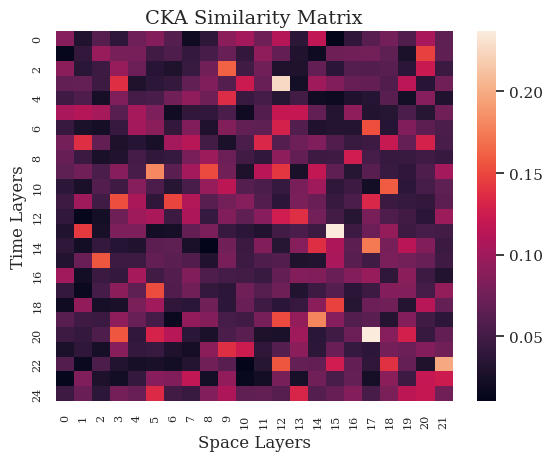

In [147]:

sns.heatmap(CKA_similairty_matrix)
plt.title("CKA Similarity Matrix", fontsize= 14)
plt.ylabel("Time Layers")
plt.xlabel("Space Layers")
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()  


In [ ]:
def lookup_function(idx_0, idx_1):
    weights_time_2d = np.squeeze(weights_time[:,0,:,0])
    V_look_up = weights_time_2d[:,idx_0].reshape(-1,1)
    subset_space = weights_space[:,0,0,:]
    space_weights_2d = np.squeeze(subset_space)
    #print(space_weights_2d.shape)
    W_look_up = space_weights_2d[:,idx_1].reshape(-1,1)
    return CKA_similairty_matrix[idx_0,idx_1]

print("Highest Values:")
print(CKA_similairty_matrix[3,12])
print(CKA_similairty_matrix[13,15])
print(CKA_similairty_matrix[20,17])


Highest Values:
0.22556032255419167
0.2363320495138961
0.23674663694913645


Mean:  0.06641252400898102
Median:  0.060221939773591984
Standard Deviation:  0.03557604616637716


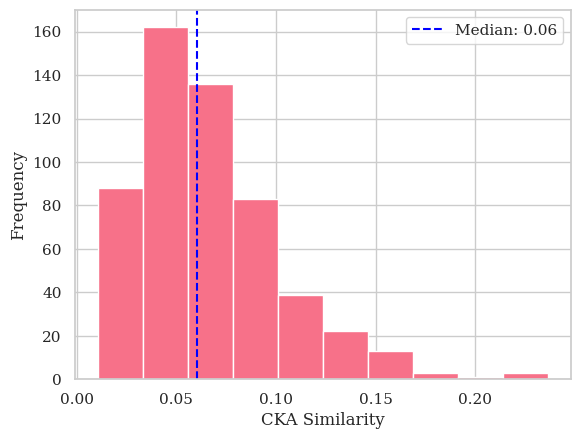

In [195]:
flat_CKA_matrix = CKA_similairty_matrix.flatten()
print("Mean: ", np.mean(flat_CKA_matrix))
print("Median: ", np.median(flat_CKA_matrix))
print("Standard Deviation: ", np.std(flat_CKA_matrix))

plt.hist(flat_CKA_matrix)
plt.ylabel("Frequency")
plt.xlabel("CKA Similarity")
#plt.title("Histogram - CKA Similarity Matrix")
plt.axvline(np.median(flat_CKA_matrix), color='b', linestyle = "--",label=f"Median: {np.median(flat_CKA_matrix):.2f}")
#plt.axvline(np.mean(flat_CKA_matrix), color='orange', linestyle = "--",label="Mean")
plt.legend()
plt.show()


#### Maybe?

#### Jackknife Boostrapping for CKA: 